In [ ]:
# upgrade scipy to be able to use qmc
# after that automatically restarts the cell
import os
! pip install scipy --upgrade
os.kill(os.getpid(), 9)


# In case you have a too recent version .......
#import tensorflow as tf
#print (tf.__version__)
#%pip install tensorflow==2.15.0
#################################################


In [18]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc
from scipy import special


In [19]:
tf.keras.backend.set_floatx("float64")

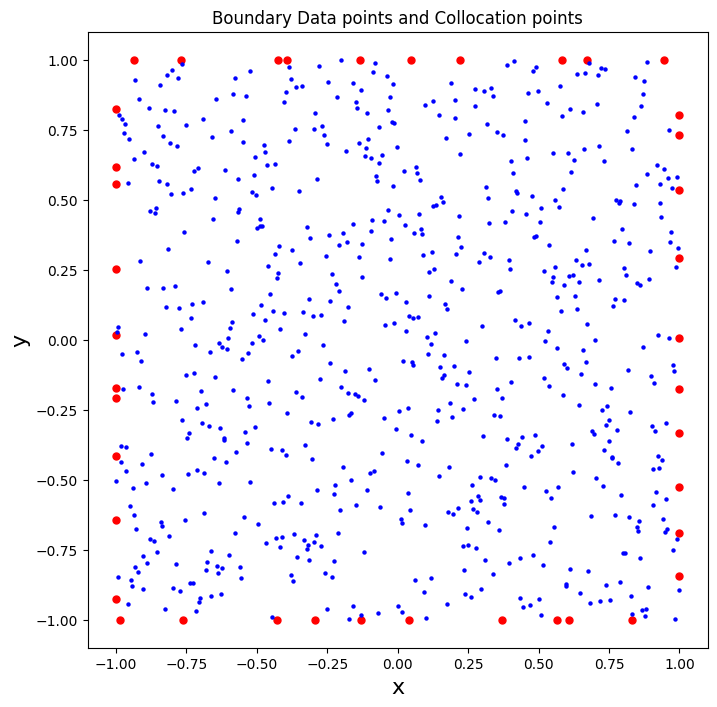

In [20]:
### data generation .... boundary solution at 4 boundaries ......
#
n_bc = 4
n_data_per_bc = 10
# ..................................................................
engine = qmc.LatinHypercube(d=1)
data = np.zeros([n_bc, n_data_per_bc, 8])
# quasi-random or regular points .................................
for i, j in zip(range(n_bc), [-1, +1, -1, +1]):
    points = (engine.random(n=n_data_per_bc)[:, 0] - 0.5) * 2
    #points = np.linspace(-1, +1, n_data_per_bc)
    if i < 2:
        data[i, :, 0] = j
        data[i, :, 1] = points
    else:
        data[i, :, 0] = points
        data[i, :, 1] = j


############### for non standard BCs .........
# select if we want a smaller square bcs ....
#data[:, :, 0:2] = data[:, :, 0:2]/2

# select if we want sinusoidal internal bcs
#data[:, :, 0] = 0.25*np.cos(2*np.pi*data[:, : , 1])



# ........................................................
# BC Values ...............................................
# Parameter values .......................
# Ed is the reconnection rate and beta controls the configuration
Ed = 0.1/2
beta = 0.75

# resistivity and viscosity values .....................
eta=0.01
etabis=0

# Add eventual noise ...............................
epsil=0.0

# secondary parameters ..................
mu=np.sqrt((1-beta**2)/2/eta)
coef= Ed/eta/mu

for j in range(0,n_data_per_bc):    
    # for B_y at x = -1 .....................................    
    data[0, j, 2] = coef*special.dawsn(mu*data[0, j, 0]) - beta*data[0, j, 1]        
    # for B_x ....................
    data[0, j, 3] =  beta*data[0, j, 0]        
    # for v_y ....................
    data[0, j, 4] = - beta*coef*special.dawsn(mu*data[0, j, 0]) + data[0, j, 1]      
    # for v_x ...................        
    data[0, j, 5] = - data[0, j, 0]       
    
    # for B_y at x = +1 ......................................
    data[1, j, 2] = coef*special.dawsn(mu*data[1, j, 0]) - beta*data[1, j, 1]        
    # for B_x .....................    
    data[1, j, 3] = beta *data[1, j, 0]      
    # for v_y .....................    
    data[1, j, 4] = - beta*coef*special.dawsn(mu*data[1, j, 0] ) + data[1, j, 1]      
    # for v_x .....................    
    data[1, j, 5] = - data[1, j, 0]      
    
for i in range(0,n_data_per_bc):
    # for B_y at y = -1 .....................................
    data[2, i, 2] = coef*special.dawsn(mu*data[2, i, 0]) - beta*data[2, i, 1]
    # for B_x ......................    
    data[2, i, 3] = beta * data[2, i, 0]
    # for v_y .......................    
    data[2, i, 4] = - beta*coef*special.dawsn(mu*data[2, i, 0]) + data[2, i, 1]
    # for v_x .......................    
    data[2, i, 5] = - data[2, i, 0]
   
    # for B_y at y = +1 .......................................
    data[3, i, 2] = coef*special.dawsn(mu*data[3, i, 0]) - beta*data[3, i, 1]
    # for B_x .........................
    data[3, i, 3] = beta * data[3, i, 0]
    # for v_y ..........................    
    data[3, i, 4] = - beta*coef*special.dawsn(mu*data[3, i, 0]) + data[3, i, 1]
    # for v_x ...........................    
    data[3, i, 5] = - data[3, i, 0]


# add noise ...
data[0:4, :, 2:6] = data[0:4, :, 2:6] * ( 1 + epsil * tf.random.normal(tf.shape(data[0:4, :, 2:6])))
   
# Reshape all the data values at boundaries ..................................
# We need also 2 extra arrays for the pressure P and the scalar function psi
data = data.reshape(n_data_per_bc * n_bc, 8)
#
x_d, y_d, t_d, t_dd, v_d, v_dd, p_d, psi_d  = map(lambda x: np.expand_dims(x, axis=1), 
  [data[:, 0], data[:, 1], data[:, 2], data[:, 3],data[:, 4],data[:, 5],data[:, 6, ],data[:, 7, ] ])


#.....................................................................
# We define the collocation points inside the domain .................
#....................................................................
# We choose the number Nc .....................
Nc = 700
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = 2 * (colloc -0.5)

# Concentrate in the middle if NECESSARY .......................
#for i in range(0,Nc,2):
#    colloc[i,0]=colloc[i,0]/2
# Again one more ..................................
#for i in range(0,Nc,2):
#    colloc[i,0]=colloc[i,0]/2

#
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])
#

plt.figure("", figsize=(8, 8))
plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker=".", c="r", s=100,label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=19, marker=".", c="b", label="CP")
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.show()

x_c, y_c, x_d, y_d, t_d, t_dd, v_d, v_dd, p_d, psi_d =map(lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
                     [x_c, y_c, x_d, y_d, t_d, t_dd, v_d, v_dd, p_d, psi_d])

In [21]:
### model builder function
def DNN_builder(in_shape=2, out_shape=6, n_hidden_layers=9, 
                neuron_per_layer=30, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(6, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

In [22]:
tf.keras.backend.clear_session()
model = DNN_builder(2, 6, 9, 30, "tanh")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)

Model: "DNN-9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 30)                90        
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 30)                930       
                                                                 
 dense_5 (Dense)             (None, 30)                930   

In [23]:
@tf.function
def u(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u
    

In [24]:
@tf.function
def f(x, y):
    up = u(x, y) 
    u0, ub0, v0, vb0, p0, psi0 = up[:,0:1], up[:,1:2], up[:,2:3], up[:,3:4], up[:,4:5], up[:,5:6]
    # We have B_y, B_x, v_y, v_x, P, and psi ...................................................  
    # and associated derivatives below ..................
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    #
    ub_x = tf.gradients(ub0, x)[0]
    ub_y = tf.gradients(ub0, y)[0]
    ub_xx = tf.gradients(ub_x, x)[0]
    ub_yy = tf.gradients(ub_y, y)[0]
    #
    psi_x = tf.gradients(psi0, x)[0]
    psi_y = tf.gradients(psi0, y)[0]    
    #
    v_x = tf.gradients(v0, x)[0]
    v_y = tf.gradients(v0, y)[0]
    v_xx = tf.gradients(v_x, x)[0]
    v_yy = tf.gradients(v_y, y)[0]    
    #
    vb_x = tf.gradients(vb0, x)[0]
    vb_y = tf.gradients(vb0, y)[0]
    vb_xx = tf.gradients(vb_x, x)[0]
    vb_yy = tf.gradients(vb_y, y)[0]
    #
    p_x = tf.gradients(p0, x)[0]
    p_y = tf.gradients(p0, y)[0]
    
    
    # To ensure the divergence free of B and velocity ....
    Fc = u_y + ub_x
    Gc = v_y + vb_x
    
    # For magnetic field .........................
    # Residual for B_y component ..................
    F = eta*(u_xx + u_yy) - vb0*u_x - v0*u_y + ub0*v_x + u0*v_y
    # Residual for B_x component ..................
    Fb = eta*(ub_xx + ub_yy) - vb0*ub_x - v0*ub_y + ub0*vb_x + u0*vb_y
    
    # For velocity flow .........................
    # Residual for v_y component ...................
    G = - vb0*v_x - v0*v_y + (u_x - ub_y)*ub0 - p_y  + etabis*(v_xx + v_yy)
    # Residual for v_x component ...................
    Gb = - vb0*vb_x - v0*vb_y + (ub_y - u_x)*u0 - p_x + etabis*(vb_xx + vb_yy)

    # To visualize the magnetic field as isocontours of psi ........
    F1 = u0 + psi_x
    F2 = ub0 - psi_y
                
    retour=  tf.reduce_mean(tf.square(F)) + tf.reduce_mean(tf.square(Fb))
    retour = retour + tf.reduce_mean(tf.square(G)) + tf.reduce_mean(tf.square(Gb)) 
    retour = retour + tf.reduce_mean(tf.square(Fc))+  tf.reduce_mean(tf.square(Gc))  
    retour = retour + tf.reduce_mean(tf.square(F1)) + tf.reduce_mean(tf.square(F2))
    # Note that F1 and F2 are necessary for plotting the correct psi ..........
    return retour

In [25]:
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

@tf.function
def msex(y, y_):
    # MSE only for boundaries at x = -/+ 1 .....
    yr = tf.reshape(y,[4, n_data_per_bc])
    yr_= tf.reshape(y_,[4, n_data_per_bc])
    yrr = yr[0:2,:]
    yrr_= yr_[0:2,:]
    retour = tf.reduce_mean(tf.square(yrr-yrr_))    
    return retour

@tf.function
def msey(y, y_):
    # MSE only for boundaries at y = -/+ 1 .......
    yr = tf.reshape(y,[4, n_data_per_bc])
    yr_= tf.reshape(y_,[4, n_data_per_bc])
    yrr = yr[2:4,:]
    yrr_= yr_[2:4,:]
    retour = tf.reduce_mean(tf.square(yrr-yrr_))    
    return retour

    0, 2.42374706
  100, 0.49445564
  200, 0.24615834
  300, 0.13003804
  400, 0.08825428
  500, 0.06925481
  600, 0.06018613
  700, 0.05514408
  800, 0.05154098
  900, 0.04855607
 1000, 0.04589217
 1100, 0.04341087
 1200, 0.04105930
 1300, 0.03882064
 1400, 0.03666844
 1500, 0.03455768
 1600, 0.03244923
 1700, 0.03033512
 1800, 0.02823309
 1900, 0.02612923
 2000, 0.02391697
 2100, 0.02144052
 2200, 0.01860568
 2300, 0.01542826
 2400, 0.01215024
 2500, 0.00943491
 2600, 0.00745123
 2700, 0.00601988
 2800, 0.00497550
 2900, 0.00418154
 3000, 0.00355362
 3100, 0.00306383
 3200, 0.00266377
 3300, 0.00232753
 3400, 0.00204768
 3500, 0.00180452
 3600, 0.00159272
 3700, 0.00141433
 3800, 0.00125450
 3900, 0.00111603
 4000, 0.00099994
 4100, 0.00089527
 4200, 0.00080516
 4300, 0.00072908
 4400, 0.00066168
 4500, 0.00060300
 4600, 0.00055254
 4700, 0.00050864
 4800, 0.00049031
 4900, 0.00043640
 5000, 0.00048550
 5100, 0.00037986
 5200, 0.00040459
 5300, 0.00033558
 5400, 0.00031796
 5500, 0.0

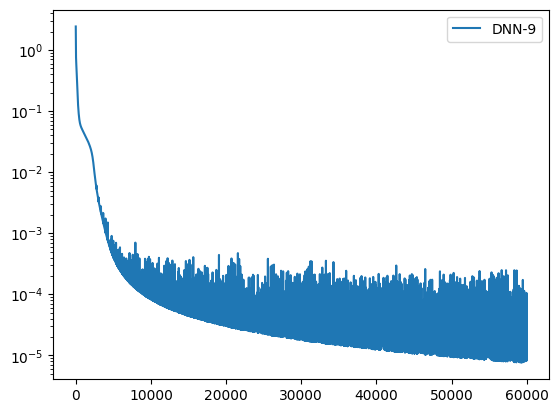

In [26]:
loss = 0
epochs = 60000
# 10 minutes on my laptop for 10000 ...........

opt = tf.keras.optimizers.legacy.Adam(learning_rate=2e-4)
epoch = 0
loss_values = np.array([])
L1_values = np.array([])
l_values = np.array([])
lb_values = np.array([])
l2_values = np.array([])
lb2_values = np.array([])

lp_values = np.array([])

#
start = time.time()
#
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        Tp = u(x_d, y_d)
        T_, Tb_ , V_, Vb_= Tp[:,0:1], Tp[:,1:2],Tp[:,2:3],Tp[:,3:4]
        
        # Loss for colloc points ..........
        L1 = f(x_c, y_c)
        # Loss at boundaries for the 4 scalars ....
        l = mse(t_d, T_)
        lb = mse(t_dd, Tb_)        
        l2 = mse(v_d, V_)          
        lb2 =  mse(v_dd, Vb_) 
        # total loss ...............
        loss =  L1 + 1*lb + 1*l + 1*l2 + 1*lb2

        
        
    g = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(g, model.trainable_weights))
    
    loss_values = np.append(loss_values, loss)
    L1_values = np.append(L1_values, L1)
    
    l_values = np.append(l_values, l)
    lb_values = np.append(lb_values, lb)
    l2_values = np.append(l2_values, l2)
    lb2_values = np.append(lb2_values, lb2)
    
    if epoch % 100 == 0 or epoch == epochs-1:
        print(f"{epoch:5}, {loss.numpy():.8f}")
        lp_values = np.append(lp_values, loss)

#
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")
#
plt.semilogy(loss_values, label=model.name)
plt.legend()

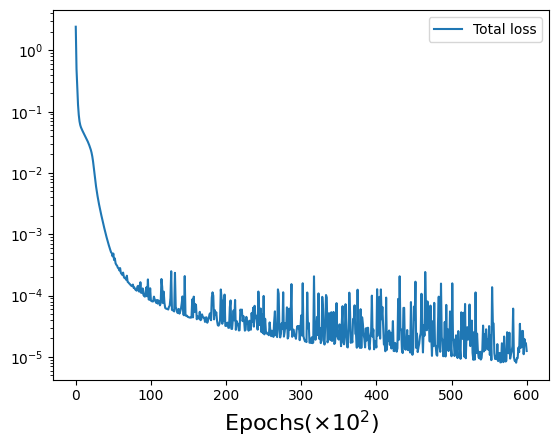

In [27]:
#plt.semilogy(loss_values, label="Total loss")

plt.semilogy(lp_values, label="Total loss")
#plt.semilogy(loss_values, label="Total loss")

plt.xlabel("Epochs" r'($\times 10^2$)',fontsize=16)
plt.legend()



# To prepare the plotting .......
n = 200
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])
TT = np.zeros([n, n])
TTT=np.zeros([n, n])
TTT2=np.zeros([n, n])



tf.Tensor(2.4202830919647846e-06, shape=(), dtype=float64)
tf.Tensor(2.0264093645739308e-07, shape=(), dtype=float64)


/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_11740/2414421395.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_11740/2414421395.py:76: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


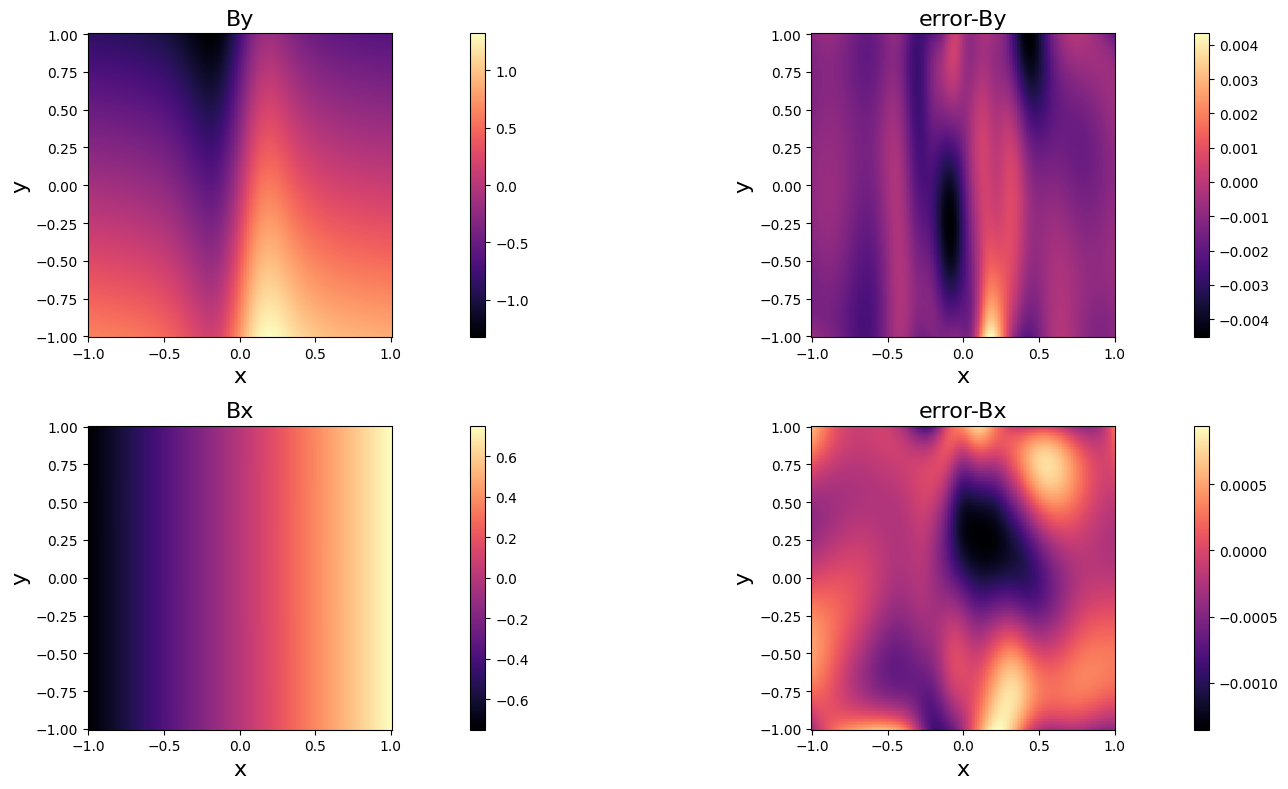

In [28]:
### plotting  ......... for B_y and B_x ................;
plt.figure("", figsize=(16, 8))
#
X = np.linspace(-1, +1, n)
Y = np.linspace(-1, +1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)

# Predict solutions ...... for B_y ...
Scomp = u(X_T, Y_T)
S = Scomp[:,0:1]
S = S.numpy().reshape(n, n)
# .... and B_x .................
S2 = Scomp[:,1:2]
S2 = S2.numpy().reshape(n, n)

#
plt.subplot(221)
pcm=plt.pcolormesh(X0, Y0, S, cmap="magma")
plt.colorbar(pcm,orientation='vertical',pad=-0.25)

plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.title("By",fontsize=16)
plt.tight_layout()
plt.axis("square")
#
x = np.linspace(-1, +1, n)
y = np.linspace(-1, +1, n)
x, y = np.meshgrid(x, y)

# Here the True solutions for B_y and B_x ....
TT = -beta*y + coef*special.dawsn(mu*x) -S
TT2 = beta*x -S2

print (tf.reduce_mean(tf.square(TT)))
print (tf.reduce_mean(tf.square(TT2)))
  
    
    
#
plt.subplot(222)
plt.pcolormesh(x, y, TT, cmap="magma")
plt.colorbar(pad=-0.25)
plt.title(r"error-By",fontsize=16)
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.tight_layout()
plt.axis("square")
#plt.savefig("heat01.png")
#
plt.subplot(224)
plt.pcolormesh(x, y, TT2, cmap="magma")
plt.colorbar(pad=-0.25)
plt.title(r"error-Bx",fontsize=16)
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.axis("square")
#plt.savefig("heat01.png")


#
plt.subplot(223)
plt.pcolormesh(X0, Y0, 1.*S2, cmap="magma")
plt.colorbar(pad=-0.25)
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.title("Bx",fontsize=16)
plt.tight_layout()
plt.axis("square")
#
x = np.linspace(-1, +1, n)
y = np.linspace(-1, +1, n)
x, y = np.meshgrid(x, y)



tf.Tensor(3.0170347750458225e-06, shape=(), dtype=float64)
tf.Tensor(2.398959321737974e-07, shape=(), dtype=float64)


/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_11740/1555186087.py:51: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_11740/1555186087.py:63: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_11740/1555186087.py:75: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


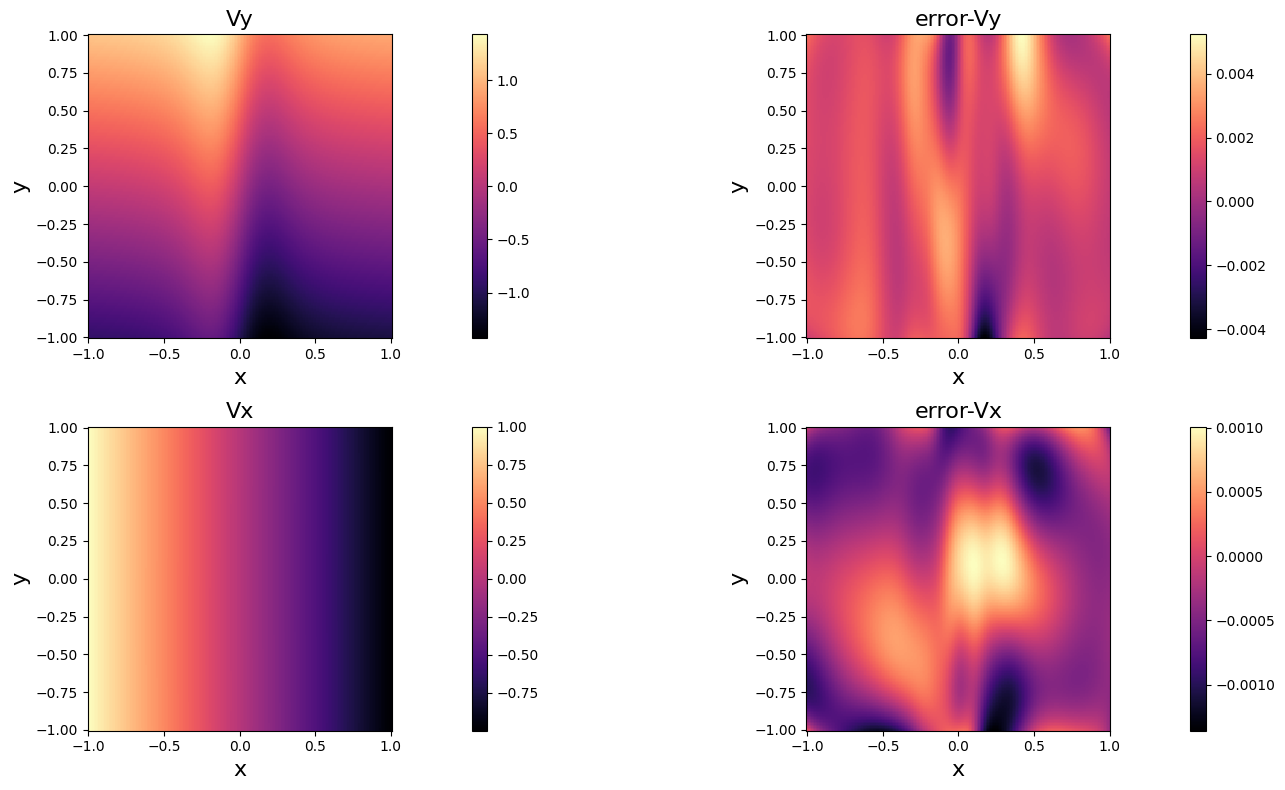

In [29]:
### plotting ....... for v_y and v_x ..............
plt.figure("", figsize=(16, 8))
#
X = np.linspace(-1, +1, n)
Y = np.linspace(-1, +1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)

# predict v_y and v_x ...........
Scomp = u(X_T, Y_T)
S = Scomp[:,2:3]
S = S.numpy().reshape(n, n)

S2 = Scomp[:,3:4]
S2 = S2.numpy().reshape(n, n)

#
plt.subplot(221)
pcm=plt.pcolormesh(X0, Y0, S, cmap="magma")
plt.colorbar(pcm,orientation='vertical',pad=-0.25)

plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.title("Vy",fontsize=16)
plt.tight_layout()
plt.axis("square")
#
x = np.linspace(-1, +1, n)
y = np.linspace(-1, +1, n)
x, y = np.meshgrid(x, y)

# True solutions for v_y and v_x ............
TT = y - beta*coef*special.dawsn(mu*x) - S
TT2 = -x -S2

print (tf.reduce_mean(tf.square(TT)))
print (tf.reduce_mean(tf.square(TT2)))

#
plt.subplot(222)
plt.pcolormesh(x, y, TT, cmap="magma")
plt.colorbar(pad=-0.25)
plt.title(r"error-Vy",fontsize=16)
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.tight_layout()
plt.axis("square")
#plt.savefig("heat01.png")
#
plt.subplot(224)
plt.pcolormesh(x, y, TT2, cmap="magma")
plt.colorbar(pad=-0.25)
plt.title(r"error-Vx",fontsize=16)
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.tight_layout()
plt.axis("square")
#plt.savefig("heat01.png")


#
plt.subplot(223)
plt.pcolormesh(X0, Y0, 1.*S2, cmap="magma")
plt.colorbar(pad=-0.25)
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.title("Vx",fontsize=16)
plt.tight_layout()
plt.axis("square")
#
x = np.linspace(-1, +1, n)
y = np.linspace(-1, +1, n)
x, y = np.meshgrid(x, y)



/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_11740/3158114206.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


(-1.0, 1.0, -1.0, 1.0)

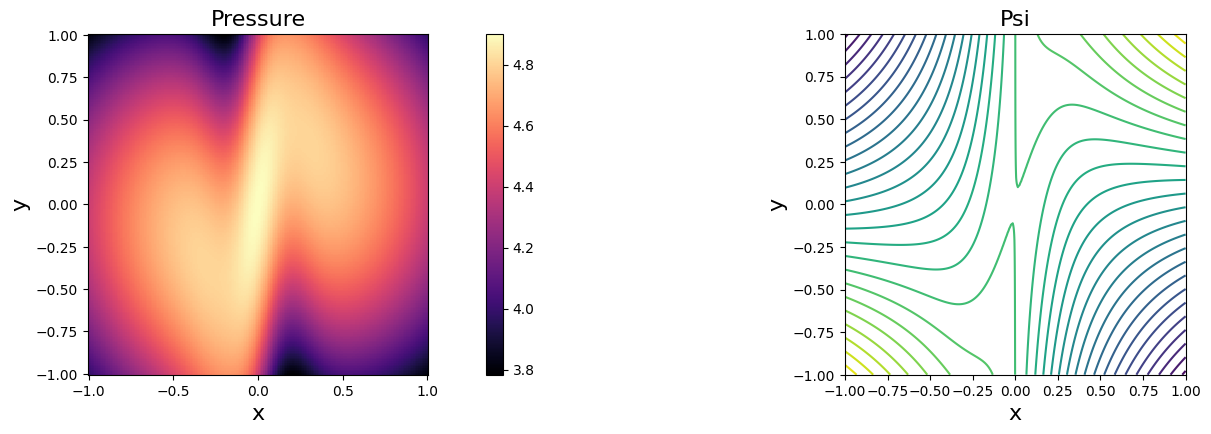

In [30]:
### plotting .... for pressure and psi -> isocontours magnetic field lines 
plt.figure("", figsize=(16, 8))
#
X = np.linspace(-1, +1, n)
Y = np.linspace(-1, +1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)

# Predict pressure and psi ........
Scomp = u(X_T, Y_T)
S = Scomp[:,4:5]
S = S.numpy().reshape(n, n)

Spsi = Scomp[:,5:6]
Spsi = Spsi.numpy().reshape(n, n)

#
plt.subplot(221)
pcm=plt.pcolormesh(X0, Y0, 1.*S, cmap="magma")
plt.colorbar(pcm,orientation='vertical',pad=-0.25)

plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.title("Pressure",fontsize=16)
plt.tight_layout()
plt.axis("square")

#
plt.subplot(222)
#pcm=plt.pcolormesh(X0, Y0, 1.*S2, cmap="magma")
#plt.colorbar(pcm,orientation='vertical',pad=-0.25)
plt.contour(x, y, Spsi,25)

plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.title("Psi",fontsize=16)
plt.tight_layout()
plt.axis("square")

#




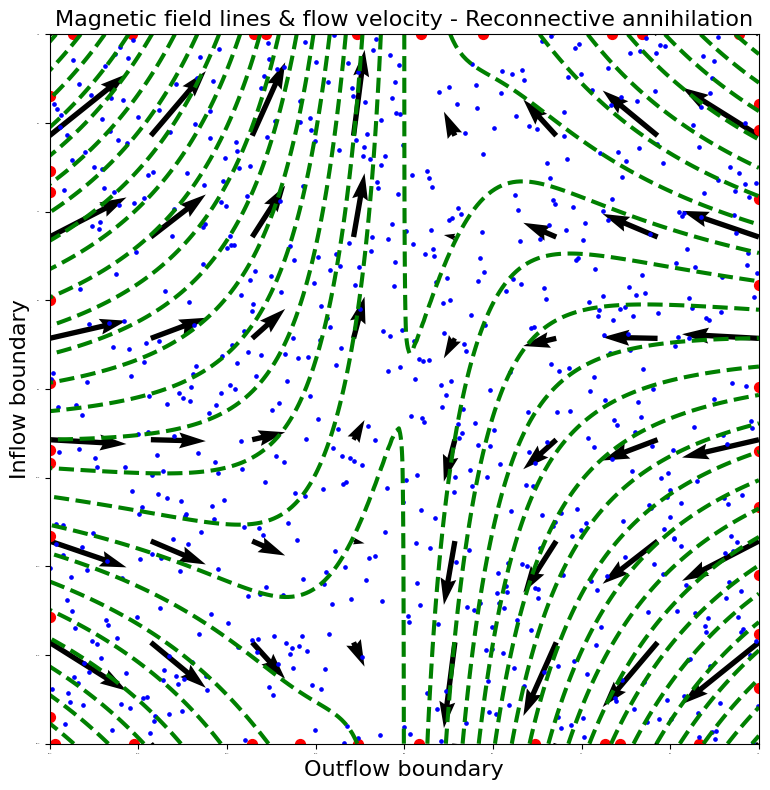

In [31]:
# Plotting magnetic field + velocity ...........
m=8
X = np.linspace(-1., +1., m)
Y = np.linspace(-1., +1., m)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([m*m, 1])
Y = Y0.reshape([m*m, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)
Scomp = u(X_T, Y_T)


S = Scomp[:,2:3]
S = S.numpy().reshape(m, m)

S2 = Scomp[:,3:4]
S2 = S2.numpy().reshape(m, m)




plt.figure("", figsize=(16, 8))
widths = np.linspace(0, 2, X.size)
plt.quiver(X,Y,1*S2,1*S,units='inches',linewidths=widths,scale=1.3)
plt.contour(x, y, Spsi,24,colors='g',linewidths=2.95,linestyles='dashed' )
plt.scatter(data[:, 0], data[:, 1], marker=".", c="r",s=200, label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=22, marker=".", c="b", label="CP")
plt.xlabel("Outflow boundary",fontsize=16)
plt.ylabel("Inflow boundary",fontsize=16)
plt.ylim(-1.01, 1.01)
plt.xlim(-1.01, +1.01)
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)
plt.title("Magnetic field lines & flow velocity - Reconnective annihilation",fontsize=16)
plt.tight_layout()
plt.axis("square")

plt.show()


x = np.linspace(-1, +1, n)
y = np.linspace(-1, +1, n)
x, y = np.meshgrid(x, y)

[99, 124, 149, 174]


/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_11740/3791204140.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_11740/3791204140.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


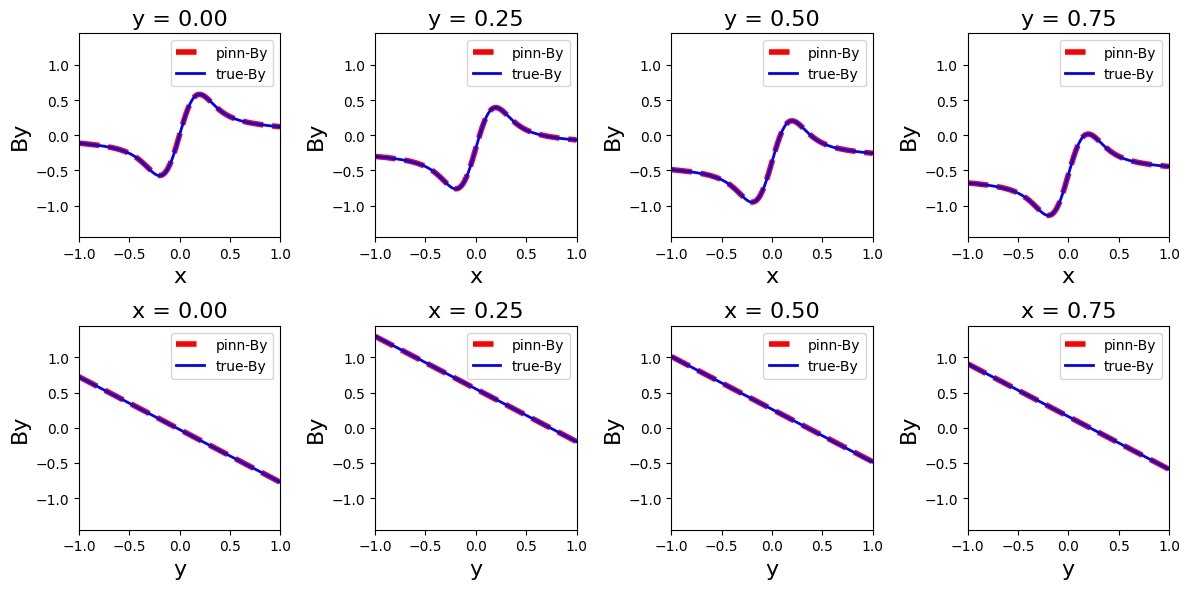

In [32]:
# To compare cuts ........ manetic field B_y ...
X = np.linspace(-1, +1, n)
Y = np.linspace(-1, +1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)


Scomp = u(X_T, Y_T)
S = Scomp[:,0:1]
S = S.numpy().reshape(n, n)
S_ = S.reshape([n, n])
# True B_y .................
T_ = -beta*y + coef*special.dawsn(mu*x)

height = 3
frames_val = np.array([0., +.25, +.5, +.75])
frames = [*map(int, (frames_val + 1)/2 * (n-1))]

print (frames)

fig = plt.figure("", figsize=(len(frames)*height, 2*height))

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), i+1)
    plt.title(f"y = {frames_val[i]:.2f}",fontsize=16)
    plt.plot(X0[var_index, :], S_[var_index,:], "r--", lw=4., label="pinn-By")
    plt.plot(X0[var_index, :], T_[var_index,:], "b", lw=2., label="true-By")
    plt.ylim(-1.45, 1.45)
    plt.xlim(-1., +1.)
    plt.xlabel("x",fontsize=16)
    plt.ylabel("By",fontsize=16)
    plt.tight_layout()
    plt.legend()

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), len(frames) + i+1)
    plt.title(f"x = {frames_val[i]:.2f}",fontsize=16)
    plt.plot(Y0[:, var_index], S_[:,var_index], "r--", lw=4., label="pinn-By")
    plt.plot(Y0[:, var_index], T_[:,var_index], "b", lw=2., label="true-By")
    plt.ylim(-1.45, 1.45)
    plt.xlim(-1., +1.)
    plt.xlabel("y",fontsize=16)
    plt.ylabel("By",fontsize=16)
    plt.tight_layout()
    plt.legend()




/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_11740/2319955045.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_11740/2319955045.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


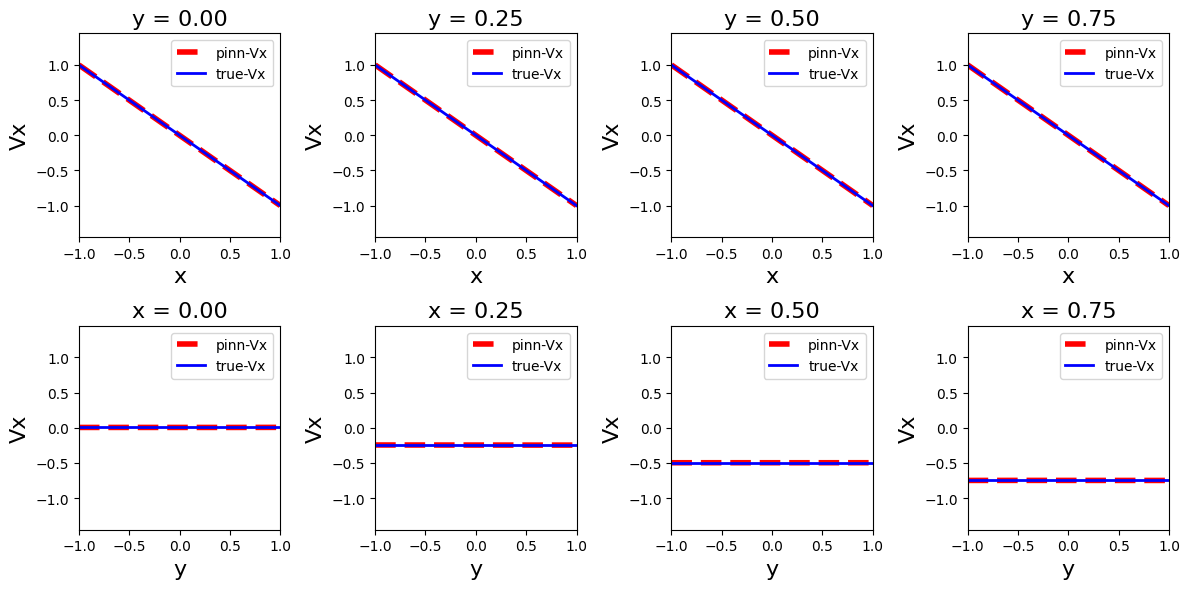

In [33]:
# Compare cuts for V_x .................
X = np.linspace(-1, +1, n)
Y = np.linspace(-1, +1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)


Scomp = u(X_T, Y_T)
S = Scomp[:,3:4]
S = S.numpy().reshape(n, n)
S_ = S.reshape([n, n])
# True v_x ....
T_ = - x

height = 3
frames_val = np.array([ 0., +.25, +.5, +.75])
frames = [*map(int, (frames_val + 1)/2 * (n-1))]
fig = plt.figure("", figsize=(len(frames)*height, 2*height))

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), i+1)
    plt.title(f"y = {frames_val[i]:.2f}",fontsize=16)
    plt.plot(X0[var_index, :], S_[var_index,:], "r--", lw=4., label="pinn-Vx")
    plt.plot(X0[var_index, :], T_[var_index,:], "b", lw=2., label="true-Vx")
    plt.ylim(-1.45, 1.45)
    plt.xlim(-1., +1.)
    plt.xlabel("x",fontsize=16)
    plt.ylabel("Vx",fontsize=16)
    plt.tight_layout()
    plt.legend()

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), len(frames) + i+1)
    plt.title(f"x = {frames_val[i]:.2f}",fontsize=16)
    plt.plot(Y0[:, var_index], S_[:,var_index], "r--", lw=4., label="pinn-Vx")
    plt.plot(Y0[:, var_index], T_[:,var_index], "b", lw=2., label="true-Vx")
    plt.ylim(-1.45, 1.45)
    plt.xlim(-1., +1.)
    plt.xlabel("y",fontsize=16)
    plt.ylabel("Vx",fontsize=16)
    plt.tight_layout()
    plt.legend()




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


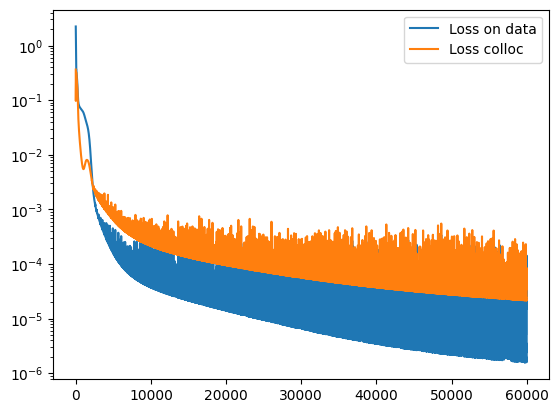

In [17]:
#plt.semilogy(loss_values, label=model.name)
plt.legend()
plt.semilogy(lb_values+l_values+l2_values+lb2_values, label="Loss on data")
plt.legend()

plt.semilogy(L1_values, label="Loss colloc")

#plt.semilogy(L1_values + lb_values+l_values+l2_values+lb2_values, label="Total Loss")

plt.legend()